# Example of Bibliography generation
(https://github.com/langchain-ai/open_deep_research)

In [1]:
SEARCH_API = "arxiv" # tavily

## Dependencies

In [2]:
# ! pip install -U -q open-deep-research
# ! pip install python-dotenv

### Load .env for all keys

In [3]:
%reload_ext dotenv
%dotenv

## Generate plan

0.0.10


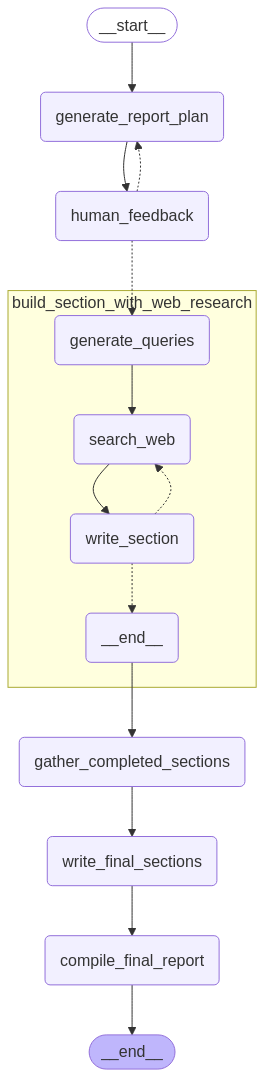

In [4]:
import open_deep_research   
print(open_deep_research.__version__) 

import os

from IPython.display import Image, display
from langgraph.types import Command
from langgraph.checkpoint.memory import MemorySaver
from open_deep_research.graph import builder

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

## Extract paper content

In [5]:
title = "LLM Evaluators Recognize and Favor Their OwnGenerations"
abstract = "Self-evaluation using large language models (LLMs) has proven valuable not onlyin benchmarking but also methods like reward modeling, constitutional AI, andself-refinement.  But new biases are introduced due to the same LLM acting asboth the evaluator and the evaluatee. One such bias is self-preference, where anLLM evaluator scores its own outputs higher than others’ while human annotatorsconsider them of equal quality. But do LLMs actually recognize their own outputswhen they give those texts higher scores, or is it just a coincidence? In this paper, weinvestigate if self-recognition capability contributes to self-preference. We discoverthat, out of the box, LLMs such as GPT-4 and Llama 2 have non-trivial accuracy atdistinguishing themselves from other LLMs and humans. By fine-tuning LLMs, wediscover a linear correlation between self-recognition capability and the strengthof self-preference bias; using controlled experiments, we show that the causalexplanation resists straightforward confounders. We discuss how self-recognitioncan interfere with unbiased evaluations and AI safety more generally."

In [6]:
# Input the paper as topic
import fitz  # PyMuPDF library is imported as 'fitz'
import sys

def extract_text_from_pdf_pymupdf(pdf_path):
    """
    Extracts text from all pages of a PDF file using PyMuPDF.

    Args:
        pdf_path (str): The file path to the PDF.

    Returns:
        str: The extracted text from the PDF, with pages separated by newlines.
             Returns None if the file cannot be processed.
    """
    try:
        doc = fitz.open(pdf_path)
    except FileNotFoundError:
        print(f"Error: File not found at '{pdf_path}'", file=sys.stderr)
        return None
    except Exception as e:
        print(f"Error opening or processing PDF '{pdf_path}': {e}", file=sys.stderr)
        return None

    all_text = ""
    print(f"Processing '{pdf_path}'...")
    with doc:  # Ensures the document is closed properly
        for page_num, page in enumerate(doc):
            try:
                page_text = page.get_text("text") # Extract text as plain text
                if page_text: # Only add if text was found
                   all_text += f"--- Page {page_num + 1} ---\n"
                   all_text += page_text.strip() + "\n\n"
            except Exception as e:
                print(f"Error extracting text from page {page_num + 1}: {e}", file=sys.stderr)
                # Optionally continue to the next page or stop
                # continue

    if not all_text:
         print("Warning: No text could be extracted. The PDF might be image-based (scanned).", file=sys.stderr)

    print(f"Finished processing '{pdf_path}'.")
    return all_text.strip() # Remove trailing newlines

# --- Example Usage ---
pdf_file = "../../data/14702_LLM_Evaluators_Recognize.pdf"

full_paper_text = extract_text_from_pdf_pymupdf(pdf_file)

Processing '../../data/14702_LLM_Evaluators_Recognize.pdf'...
Finished processing '../../data/14702_LLM_Evaluators_Recognize.pdf'.


## Start generating 

In [7]:
import uuid 
from IPython.display import Markdown

REPORT_STRUCTURE = """Use this structure to create a bibliography on the user-provided paper:

1. Abstract
   - Brief overview of the topic area

2. Main Body Sections:
   - Each section's title is the same as each user-provided paper's section title.
   
3. Conclusion
   - Aim for 1 structural element (either a list of table) that distills the main body sections 
   - Provide a concise summary of the bibliography"""

thread = {"configurable": {"thread_id": str(uuid.uuid4()),
                           "search_api": SEARCH_API,
                           "planner_provider": os.environ["MODEL_PROVIDER"],
                           "planner_model": os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
                           "writer_provider": os.environ["MODEL_PROVIDER"],
                           "writer_model": os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"], 
                           "report_structure": REPORT_STRUCTURE,
                           "max_search_depth": 1,}
                           } 

topic = "Bibliograp hy of the paper : " + title

# Run the graph until the interruption
async for event in graph.astream({"paper_content":full_paper_text,
                                  "title": title,
                                  "abstract": abstract,
                                  "topic": topic
                                  }, thread, stream_mode="updates"):

   if '__interrupt__' in event:
        interrupt_value = event['__interrupt__'][0].value
        display(Markdown(interrupt_value))
   

Please provide feedback on the following bibliography plan. 
                        

Section: Abstract and Introduction
Description: Overview of the paper’s primary focus on LLMs' self-evaluation, self-recognition, and self-preference biases, including initial motivation.
Research needed: Yes


Section: Definition and Measurement
Description: Detailed discussion of the operational definitions and measurement techniques for self-preference and self-recognition as presented in the paper.
Research needed: Yes


Section: Experimental Methodology and Results
Description: Examination of the experiment design, including pairwise and individual assessment protocols, datasets, and evaluation metrics used in the paper.
Research needed: Yes


Section: Fine-Tuning and Correlation Analysis
Description: Focus on the fine-tuning methods used to alter self-recognition and the subsequent linear correlation observed with self-preference bias.
Research needed: Yes


Section: Related Work
Description: Citations covering previous studies on self-evaluation bias, cognitive biases in LLMs, and detection of LLM-generated text, closely linked to the paper’s literature review.
Research needed: Yes


Section: Discussion and Safety Implications
Description: Analysis of the broader implications of self-recognition on AI safety, potential biases, and related risks such as reward hacking and adversarial vulnerabilities.
Research needed: Yes


Section: Conclusion
Description: Summary of main findings, distilled implications for LLM evaluation practices, and outlines of future research directions.
Research needed: Yes


                        
Does the bibliography plan meet your needs?
Pass 'true' to approve the bibliography plan.
Or, provide feedback to regenerate the bibliography plan:

In [8]:
# import pprint
# pprint.pprint(event, indent=2, width=120) # Adjust width as needed


In [9]:
# # Pass feedback to update the report plan  
# feedback = "That's a good plan."
# async for event in graph.astream(Command(resume=feedback), thread, stream_mode="updates"):
#     if '__interrupt__' in event:
#         interrupt_value = event['__interrupt__'][0].value
#         display(Markdown(interrupt_value))

In [ ]:
# Pass True to approve the report plan 
async for event in graph.astream(Command(resume=True), thread, stream_mode="updates"):
    print(event)
    print("\n")

{'human_feedback': None}


{'build_section_with_web_research': {'completed_sections': [Section(name='Conclusion', description='Summary of main findings, distilled implications for LLM evaluation practices, and outlines of future research directions.', research=True, content='## Conclusion\n\nOur review of recent studies reveals key insights for LLM evaluation practices. Multiple works demonstrate that evaluators often favor outputs that are confident—even when containing falsehoods—over those with cautionary disclaimers [1]. This preference can inadvertently guide LLM training toward generating misleading information. Further, research on reasoning under manipulated evidence shows that LLMs struggle with distorted inputs, indicating a significant drop in performance when facing perturbed facts [2]. Evaluations on code comprehension and generation tasks have also underscored that instruction tuning and demonstration examples can improve performance, but sometimes at the cost of consiste

In [ ]:
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

<IPython.core.display.Markdown object>

In [ ]:
Markdown(report)

<IPython.core.display.Markdown object>

In [ ]:
report